### Denoising-style Reverse Diffusion 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch,torchvision
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Util code

In [2]:
def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch
def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy() # ndarray
    return x_np
def gather_and_reshape(values,steps,x_shape):
    values_gather = torch.gather(input=values,dim=-1,index=steps.cpu())
    n_batch = steps.shape[0]
    out_shape = (n_batch,) + ((1,)*(len(x_shape)-1))
    values_gather_reshape = values_gather.reshape(shape=out_shape)
    return values_gather_reshape.to(steps.device)
print ("Ready")

Ready


`DDPM` Equations \
Forward diffusion process:
$$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$$
$$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

Reverse diffusion process posterior:
$$ 
q(x_{t-1}|x_t,x_0) = \mathcal{N}
\left(
x_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

Default DDPM Hyper-parameters:
$\beta_1 = 10^{-4}$, $\beta_T = 0.02$, $T=1,000$ \
Here, we modified $\beta_1$ to be $0.001$ and $\beta_T$ to be $0.01$.

Ready.


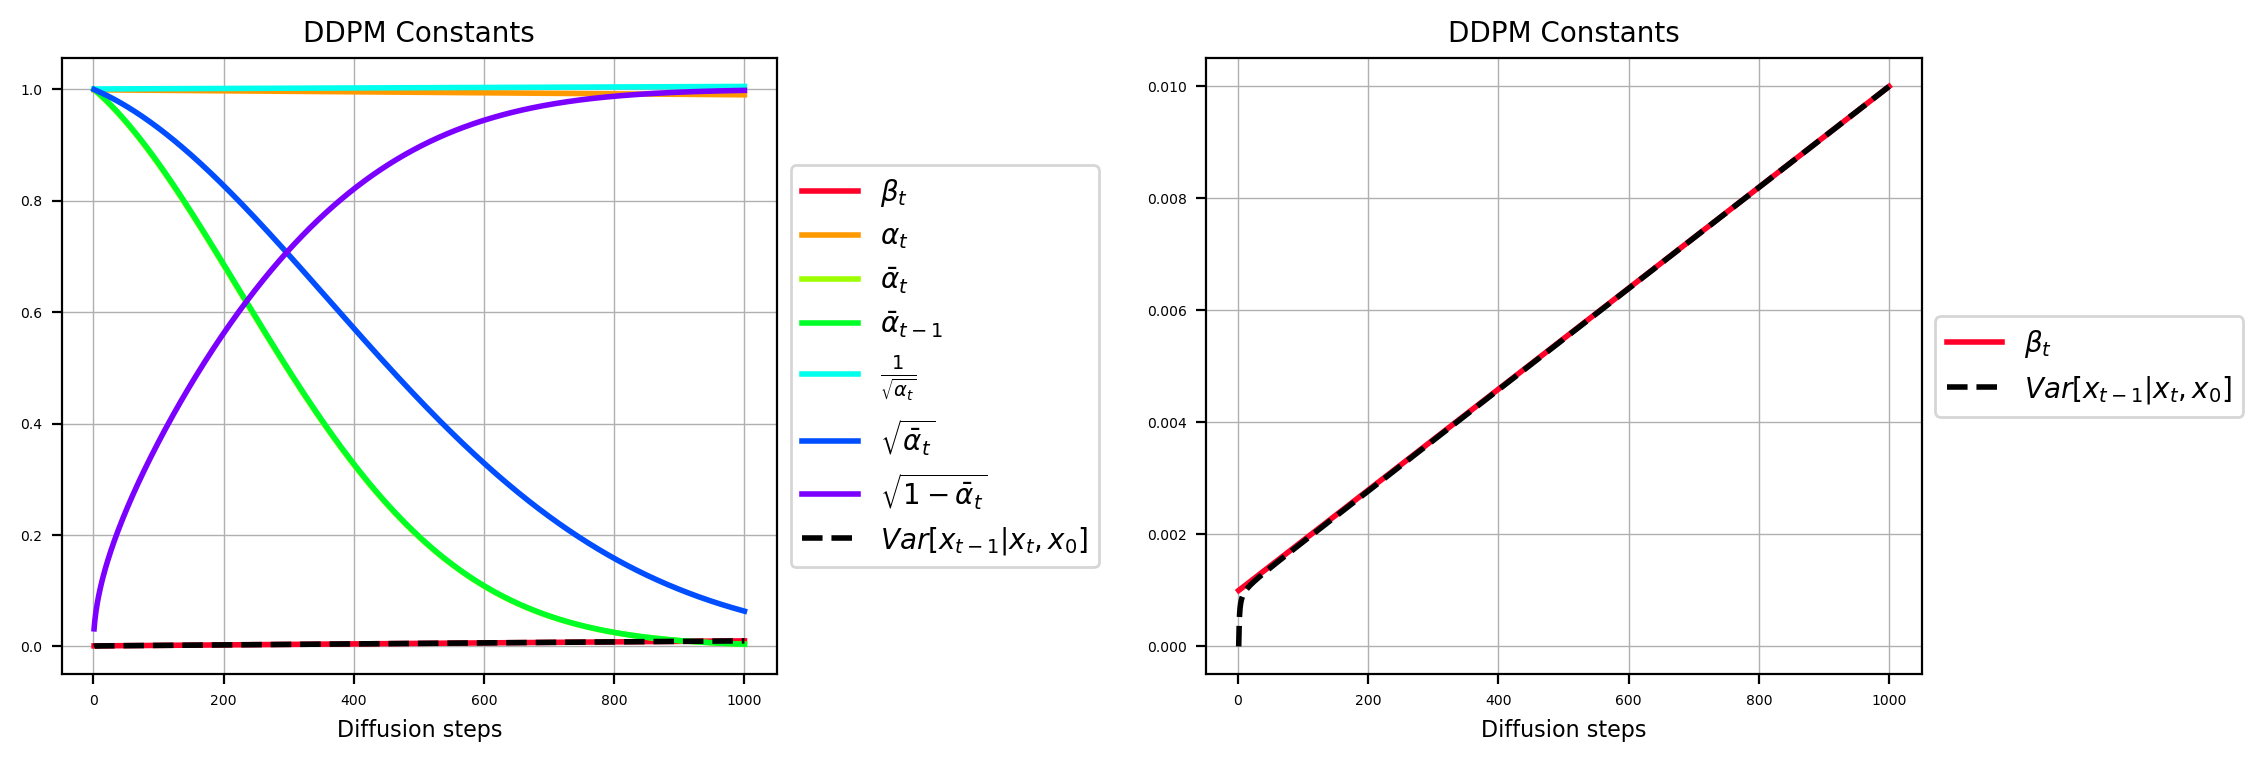

In [7]:
# Precompute some constants for DDPM
dc = {}
dc['T'] = 1000
dc['betas'] = torch.linspace(start=0.001,end=0.01,steps=dc['T']) # [T]
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

### `Algorithm 1` Training
1: $\mathbf{x}_0 \sim q( \mathbf{x}_0 )$ \
2: $t \sim \text{Uniform}(\{ 1, \ldots, T \})$ \
3: $ \boldsymbol{\color{red} \epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
4: Take gradient descent step on 
$$ 
    \nabla \| \boldsymbol{\color{red} \epsilon} - \boldsymbol{\epsilon}_{\theta}(
        \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{red} \epsilon}, t
        ) \|^2
$$

### `Algorithm 2` Sampling
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
2: for $t=T,\ldots,1$ do \
3: $\quad$ $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$ \
4: $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}
        \left(
            \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}
            \boldsymbol{\epsilon}_{\theta}(\mathbf{x},t)
        \right)
        + \sigma_t \mathbf{z}
    $ \
5: end for \
6: return $\mathbf{x}_0$

### Forward diffusion sampler

In [4]:
def forward_hilbert_diffusion_sample(x_0,K_chols,steps,dc,noise_rate=1.0):
    """
        x_0: torch.Tensor [B x L x D]
        K_chols: torch.Tensor [L x L x D]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    x_t_mean = sqrt_alphas_bar_t * x_0 # [B x L x D]
    x_t_std = sqrt_one_minus_alphas_bar_t # [B x L x D]
    # Correlated noise sampling 
    noise = torch.randn_like(input=x_0) # [B x L x D]
    noise_expand = noise[:,:,None,:] # [B x L x 1 x D]
    K_chols_torch_tile = torch.tile(input=K_chols,dims=(x_0.shape[0],1,1,1)) # [B x L x L x D]
    correlated_noise_permuted = K_chols_torch_tile.permute(0,3,1,2) @ \
        noise_expand.permute(0,3,1,2) # [B x D x L x 1]
    correlated_noise = correlated_noise_permuted.permute(0,2,3,1) # [B x L x 1 x D]
    correlated_noise_squeeze = correlated_noise.squeeze(dim=2) # [B x L x D]
    # Sample with correlated noise
    x_t = x_t_mean + noise_rate*x_t_std*correlated_noise_squeeze
    return x_t,correlated_noise_squeeze
print ("Ready.")

Ready.
